In [12]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
#Mertics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

%matplotlib inline

c:\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
#Convert string timestamp format to timestamp
## https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
data = pd.read_csv("AirPassengers.csv", index_col= 'Month')
data.index = pd.to_datetime(data.index, format="%Y-%m")


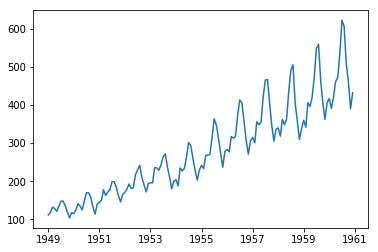

In [14]:
plt.plot(data)

### Decide Metric 

* **R squared**, coefficient of determination (in econometrics it can be interpreted as a percentage of variance explained by the model)
* **Mean Absolute Error** it is an interpretable metric because it has the same unit of measurement as the initial series
* Median Absolute Error, again an interpretable metric, particularly interesting because it is robust to outliers
* Mean Squared Error, most commonly used, gives higher penalty to big mistakes and vise versa
* Mean Squared Logarithmic Error, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends
* Mean Absolute Percentage Error, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management

In [15]:
#Calculate Mean Absolute Percentage
def mean_absolute_percentage_error(y_true, y_pred):
    return (100 * np.sum(np.abs(y_true - y_pred)))/len(y_true)
    

### Baseline 1 - Moving Average
Follows that today is prediction the mean of the previous days value

In [16]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.mean(series[-n:])   # DF.tail can also be used in case of dataframes

moving_average(data, 10) # prediction for the last observed day (past 10 months)


#Passengers    490.6
dtype: float64

** Smoothing **
are designed to reduce or eliminate short-term volatility in data. A smoothed series is preferred to a non-smoothed one because it may capture changes in the direction of the economy better than the unadjusted series does
Besides seasonal adjustments, we can smooth the trends using moving averages. There is a downside to using a moving average to smooth a data series. As the calculation relies on historical data, some of the variable's timeliness is lost. “Weighted” moving average can be used, where the more current values of the variable are given more importance. Another way to reduce the reliance on past values is to calculate a “centered” moving average, where the current value is the middle value in a five-month average, with two lags and two leads.
** Anomaly Detection System **
Calculate using CI bounds and finding any outliers

In [17]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    #The wider the window,smoothing of the original time series to indicate trends. 
    #Pandas has an implementation available DataFrame.rolling(window).mean(). 
    #The wider the window - the smoother will be the trend. In the case of the very noisy data, which can be very often encountered in finance, this procedure can help to detect common patterns.
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    #Confidence Interval 
    if plot_intervals:
        #Calculate deviation rolling_mean - (mae + scale * deviation)
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        upper_bound = rolling_mean + (mae + scale * deviation)
        lower_bound = rolling_mean - (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper bound / Lower bound")
        plt.plot(lower_bound, "r--")
    # Having the intervals, find abnormal values
    if plot_anomalies:
        anomalies = pd.DataFrame(columns = series.columns, index=series.index) #Creates an empyty dataframe with index
        anomalies[series < lower_bound] = series[series < lower_bound]
        anomalies[series > upper_bound] = series[series > upper_bound]
        #To make pointers
        plt.plot(anomalies,"ro", markersize = 10)
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
# https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

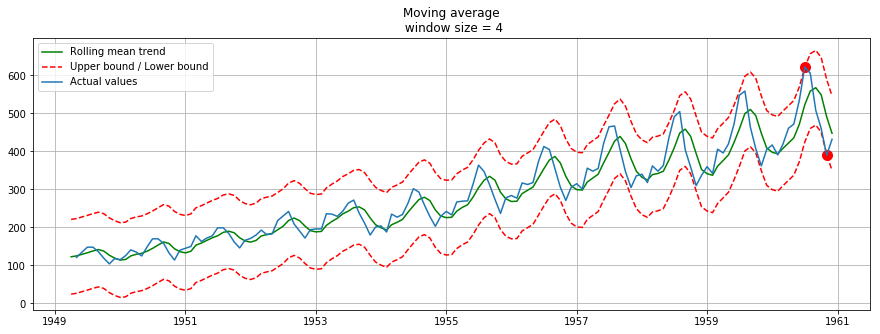

In [18]:
plotMovingAverage(data,4, plot_intervals= True, plot_anomalies = True)

### Baseline 2 - Weighted Average 
Add weight to average, generallly recent values have more weight

In [19]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    index = list(range(0, len(weights)))
    index.reverse()
    result = 0           
    n = len(series)
    for j,i in enumerate(index):
        result += weights[i] * series.iloc[n-j-1]
        print(series.iloc[n-j-1])
    return result
    

In [20]:
weighted_average(data, [0.6, 0.3, 0.1])

#Passengers    432
Name: 1960-12-01 00:00:00, dtype: int64
#Passengers    390
Name: 1960-11-01 00:00:00, dtype: int64
#Passengers    461
Name: 1960-10-01 00:00:00, dtype: int64


#Passengers    436.8
Name: 1960-12-01 00:00:00, dtype: float64

### Baseline 3- Exponential Smothing
we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:
$$ \hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$
The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller α is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1−\alpha)$ each time, which already contains a multiplication by $(1−\alpha)$ of previous model values.

In [21]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

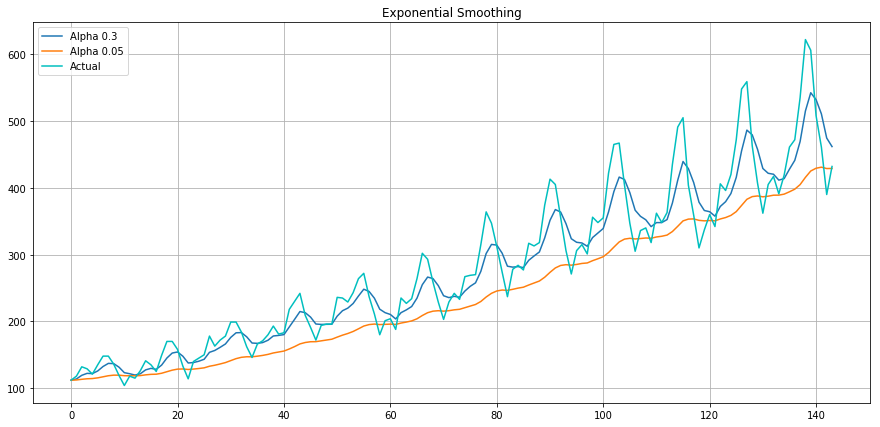

In [22]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    plt.figure(figsize=(15, 7))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")

    plt.legend(loc="best")
    plt.title("Exponential Smoothing")
    plt.grid(True)
plotExponentialSmoothing(data['#Passengers'], [0.3, 0.05])


### Baseline 4- Double exponential smoothing 
So now we have two components to a series: level and trend. In Part I we learned several methods to forecast the level, and it should follow that every one of these methods can be applied to the trend just as well. E.g. the naive method would assume that trend between last two points is going to stay the same, or we could average all slopes between all points to get an average trend, use a moving trend average or apply exponential smoothing.

Double exponential smoothing then is nothing more than exponential smoothing applied to both level and trend. To express this in mathematical notation we now need three equations: one for level, one for the trend and one to combine the level and trend to get the expected $\hat{y}$
$$
\\
\begin{align}
& \ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})& \mbox{level} \\
& b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1} & \mbox{trend} \\
& \hat{y}_{x+1} = \ell_x + b_x & \mbox{forecast}\\
\end{align}
\\
$$
The first equation is from exponential moothing, only now we’re using $ℓ_x$ instead of $\hat{y}$ and on the right side the expected value becomes the sum of level end trend.

The second equation introduces $\beta$, the trend factor (or coefficient). As with $\alpha$, some values of $\beta$ work better than others depending on the series.


In [23]:

# given a series and alpha, return series of smoothed points
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

# [3, 17.0, 15.45, 14.210500000000001, 11.396044999999999, 8.183803049999998, 12.753698384500002, 13.889016464000003]
series = [3,10,12,13,12,10,12]
double_exponential_smoothing(series, alpha=0.9, beta=0.9)


[3,
 17.0,
 15.45,
 14.210500000000001,
 11.396044999999999,
 8.183803049999998,
 12.753698384500002,
 13.889016464000003]

##### Terminology
* **Season** : *L*
If a series appears to be repetitive at regular intervals, such an interval is referred to as a season, and the series is said to be seasonal. Seasonality is required for the Holt-Winters method to work, non-seasonal series (e.g. stock prices) cannot be forecasted using this method.
* **Season Length**: 
It is the number of data points after which a new season begins. We will use L to denote season length.

* **Seasonal Component**:
The seasonal component is an additional deviation from level + trend that repeats itself at the same offset into the season. There is a seasonal component for every point in a season, i.e. if your season length is 12, there are 12 seasonal components. We will use s to denote the seasonal component.



### Baseline 4- Triple exponential smoothing a.k.a. Holt-Winters
The idea behind triple exponential smoothing is to apply exponential smoothing to the seasonal components in addition to level and trend. The smoothing is applied across seasons, e.g. the seasonal component of the 3rd point into the season would be exponentially smoothed with the the one from the 3rd point of last season, 3rd point two seasons ago, etc. In math notation we now have four equations.
$$
\begin{align}
& \ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})& \mbox{level} \\
& b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1} & \mbox{trend} \\
& s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L} & \mbox{seasonal} \\
& \hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}& \mbox{forecast}\\
\end{align}
$$
Features - 
* $\gamma$ (gamma) is the smoothing factor for the seasonal component.
* The expected value index is x+m where m can be any integer meaning we can forecast any number of points into the future
* The forecast equation now consists of level, trend and the seasonal component.
* The index of the seasonal component of the forecast $ s_{x-L+1+(m-1)modL}$ is the offset into the list of seasonal components from the last set from observed data. (I.e. if we are forecasting the 3rd point into the 45 seasons into the future, we cannot use seasonal components from the 44th season in the future since that season is also forecasted, we must use the last set of seasonal components from observed points, or from “the past” if you will.) 
* **Initial Trend**:
For double exponential smoothing we simply used the first two points for the initial trend. With seasonal data we can do better than that, since we can observe many seasons and can extrapolate a better starting trend. The most common practice is to compute the average of trend averages across seasons.
$$ b_0 = \dfrac{1}{L}\left(\dfrac{y_{L+1}-y_1}{L}+\dfrac{y_{L+2}-y_2}{L}+...+\dfrac{y_{L+L}-y_L}{L}\right) $$
* **Initial Seasonal Components**:
The situation is even more complicated when it comes to initial values for the seasonal components. Briefly, we need to compute the average level for every observed season we have, divide every observed value by the average for the season it’s in and finally average each of these numbers across our observed seasons.
* **Selecting $\alpha$ and $\beta$ **: 
it was done by way of trial and error: simply running the algorithm over and over again and selecting the values that give you the smallest SSE. As I mentioned before, this process is known as fitting.
 
 
https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/

In [24]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

### Time series cross validation


The idea is rather simple -- we train our model on a small segment of the time series from the beginning until some t, make predictions for the next t+n steps, and calculate an error. Then, we expand our training sample to t+n value, make predictions from t+n until t+2∗n, and continue moving our test segment of the time series until we hit the last available observation. As a result, we have as many folds as n will fit between the initial training sample and the last observation.
![alt text](https://i.stack.imgur.com/fXZ6k.png "Logo Title Text 1")


In [25]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [ ]:
%%time
data = data.astype(float)
dt = data[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(dt, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(dt, slen = 12, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 1, scaling_factor = 3)
model.triple_exponential_smoothing()

In [31]:
data.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64